# *Automate sentiment analysis of textual comments and feedback*

The data Used in this project is an open source data acquired from the following link below:
https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment

In [1]:
pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 9.4 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import emoji
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

### Data Extraction

In [3]:
file_path = '/content/drive/MyDrive/Tweets.csv'
df =pd.read_csv(file_path)

In [4]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

As we can see there are some unnecessary columns in the dataset that are not relevant for text based sentiment prediction like tweet_id, name, tweet_created, retweet_count, tweet_coord, user_timezone

In [6]:
df = df.drop(columns=['tweet_id','name','retweet_count', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone'])

In [7]:
df.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,negativereason_gold,text
0,neutral,1.0000,NaN,NaN,Virgin America,NaN,NaN,@VirginAmerica What @dhepburn said.
1,positive,0.3486,NaN,0.0000,Virgin America,NaN,NaN,@VirginAmerica plus you've added commercials t...
2,neutral,0.6837,NaN,NaN,Virgin America,NaN,NaN,@VirginAmerica I didn't today... Must mean I n...
3,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,NaN,@VirginAmerica it's really aggressive to blast...
4,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,NaN,@VirginAmerica and it's a really big bad thing...


In [8]:
df[df['airline_sentiment_confidence']<=0.6]

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,negativereason_gold,text
1,positive,0.3486,NaN,0.0,Virgin America,NaN,NaN,@VirginAmerica plus you've added commercials t...
114,positive,0.3482,NaN,0.0,Virgin America,NaN,NaN,@VirginAmerica come back to #PHL already. We n...
142,neutral,0.3550,NaN,0.0,Virgin America,NaN,NaN,@VirginAmerica Can you find us a flt out of LA...
183,positive,0.3579,NaN,0.0,Virgin America,NaN,NaN,😎 RT @VirginAmerica: You’ve met your match. Go...
309,neutral,0.3750,NaN,0.0,Virgin America,NaN,NaN,@VirginAmerica is saving my sanity right now: ...
...,...,...,...,...,...,...,...,...
14261,positive,0.3642,NaN,0.0,American,NaN,NaN,@AmericanAir shoutout to the agent on duty now...
14297,positive,0.3611,NaN,0.0,American,NaN,NaN,@AmericanAir Haha I had a boarding pass for 12...
14414,neutral,0.3367,NaN,0.0,American,NaN,NaN,@AmericanAir flight 1041 is the first flight.
14530,positive,0.3646,NaN,0.0,American,NaN,NaN,@AmericanAir thanks for forcing me to check -i...


There are many low confidence scores present in airline_sentiment_confidence column which can be unreliable leading to incorrect training of the model.

In [9]:
df = df[df['airline_sentiment_confidence']>= 0.6].reset_index(drop = True)
df.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,negativereason_gold,text
0,neutral,1.0000,NaN,NaN,Virgin America,NaN,NaN,@VirginAmerica What @dhepburn said.
1,neutral,0.6837,NaN,NaN,Virgin America,NaN,NaN,@VirginAmerica I didn't today... Must mean I n...
2,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,NaN,@VirginAmerica it's really aggressive to blast...
3,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,NaN,@VirginAmerica and it's a really big bad thing...
4,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,NaN,@VirginAmerica seriously would pay $30 a fligh...


After inspecting all the remaining columns we can infer that columns (airline_sentiment_confidence, negativereason, negativereason_gold, negativereason_confidence, airline_sentiment_gold) are not required for training the model as they may cause data leakage or the model might learn to rely on these rather than learning from the text.


Also airline column is not required as we need a sentiment analysis model that can classify for any airline than being biased towards a specific airlines.


In [10]:
df = df.drop(columns = ['airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline','airline_sentiment_gold', 'negativereason_gold'])

In [11]:
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,neutral,@VirginAmerica I didn't today... Must mean I n...
2,negative,@VirginAmerica it's really aggressive to blast...
3,negative,@VirginAmerica and it's a really big bad thing...
4,negative,@VirginAmerica seriously would pay $30 a fligh...


### Data Preprocessing

Lets convert all the upper case letters to lower case letters in the text column so to make the text processing case insensitive.

In [12]:
df['clean_text'] = df['text'].str.lower()
df['clean_text']

,clean_text
0,@virginamerica what @dhepburn said.
1,@virginamerica i didn't today... must mean i n...
2,@virginamerica it's really aggressive to blast...
3,@virginamerica and it's a really big bad thing...
4,@virginamerica seriously would pay $30 a fligh...
...,...
14397,@americanair right on cue with the delays👌
14398,@americanair leaving over 20 minutes late flig...
14399,@americanair please bring american airlines to...
14400,"@americanair you have my money, you change my ..."


There could be Urls present in the text. So lets find out if there are any Urls

In [13]:
url_pattern = r'http[s]?://\S+'

In [14]:
df['urls'] = df['clean_text'].str.contains(url_pattern, regex = True)
df[df['urls'] == True]

,airline_sentiment,text,clean_text,urls
6,neutral,@VirginAmerica Really missed a prime opportuni...,@virginamerica really missed a prime opportuni...,True
12,positive,@VirginAmerica @virginmedia I'm flying your #f...,@virginamerica @virginmedia i'm flying your #f...,True
20,positive,@VirginAmerica I love this graphic. http://t.c...,@virginamerica i love this graphic. http://t.c...,True
33,positive,@VirginAmerica this is great news! America co...,@virginamerica this is great news! america co...,True
34,neutral,Nice RT @VirginAmerica: Vibe with the moodligh...,nice rt @virginamerica: vibe with the moodligh...,True
...,...,...,...,...
14311,positive,@AmericanAir I hope you like the photo :) http...,@americanair i hope you like the photo :) http...,True
14345,negative,@AmericanAir seems like queue times are very h...,@americanair seems like queue times are very h...,True
14363,neutral,http://t.co/EIw2sYb8Fu roberts&amp;s=1 @Americ...,http://t.co/eiw2syb8fu roberts&amp;s=1 @americ...,True
14388,positive,@AmericanAir Flight 236 was great. Fantastic c...,@americanair flight 236 was great. fantastic c...,True


In [15]:
df = df.drop(columns = ['urls'])

There are 1150 rows with urls we need to remove those Urls from the clean_text column

In [16]:
df['clean_text'] = df['clean_text'].apply(lambda text: re.sub(url_pattern, '', text))
df

,airline_sentiment,text,clean_text
0,neutral,@VirginAmerica What @dhepburn said.,@virginamerica what @dhepburn said.
1,neutral,@VirginAmerica I didn't today... Must mean I n...,@virginamerica i didn't today... must mean i n...
2,negative,@VirginAmerica it's really aggressive to blast...,@virginamerica it's really aggressive to blast...
3,negative,@VirginAmerica and it's a really big bad thing...,@virginamerica and it's a really big bad thing...
4,negative,@VirginAmerica seriously would pay $30 a fligh...,@virginamerica seriously would pay $30 a fligh...
...,...,...,...
14397,negative,@AmericanAir right on cue with the delays👌,@americanair right on cue with the delays👌
14398,negative,@AmericanAir leaving over 20 minutes Late Flig...,@americanair leaving over 20 minutes late flig...
14399,neutral,@AmericanAir Please bring American Airlines to...,@americanair please bring american airlines to...
14400,negative,"@AmericanAir you have my money, you change my ...","@americanair you have my money, you change my ..."


As we can see clearly that there are many mentions with '@' in the text. These mentions needs to be removed from the text as they do not contribute in sentiment of the text.

In [17]:
mentions = r'@\w+'

In [18]:
df['clean_text'] = df['clean_text'].apply(lambda text: re.sub(mentions, '', text))
df

,airline_sentiment,text,clean_text
0,neutral,@VirginAmerica What @dhepburn said.,what said.
1,neutral,@VirginAmerica I didn't today... Must mean I n...,i didn't today... must mean i need to take an...
2,negative,@VirginAmerica it's really aggressive to blast...,"it's really aggressive to blast obnoxious ""en..."
3,negative,@VirginAmerica and it's a really big bad thing...,and it's a really big bad thing about it
4,negative,@VirginAmerica seriously would pay $30 a fligh...,seriously would pay $30 a flight for seats th...
...,...,...,...
14397,negative,@AmericanAir right on cue with the delays👌,right on cue with the delays👌
14398,negative,@AmericanAir leaving over 20 minutes Late Flig...,leaving over 20 minutes late flight. no warni...
14399,neutral,@AmericanAir Please bring American Airlines to...,please bring american airlines to #blackberry10
14400,negative,"@AmericanAir you have my money, you change my ...","you have my money, you change my flight, and ..."


Converting Emojis into text as emoji can also provide sentiments

In [19]:
df['clean_text'] = df['clean_text'].apply(lambda text : emoji.demojize(text, delimiters=(" :"," ")))
df

,airline_sentiment,text,clean_text
0,neutral,@VirginAmerica What @dhepburn said.,what said.
1,neutral,@VirginAmerica I didn't today... Must mean I n...,i didn't today... must mean i need to take an...
2,negative,@VirginAmerica it's really aggressive to blast...,"it's really aggressive to blast obnoxious ""en..."
3,negative,@VirginAmerica and it's a really big bad thing...,and it's a really big bad thing about it
4,negative,@VirginAmerica seriously would pay $30 a fligh...,seriously would pay $30 a flight for seats th...
...,...,...,...
14397,negative,@AmericanAir right on cue with the delays👌,right on cue with the delays :OK_hand
14398,negative,@AmericanAir leaving over 20 minutes Late Flig...,leaving over 20 minutes late flight. no warni...
14399,neutral,@AmericanAir Please bring American Airlines to...,please bring american airlines to #blackberry10
14400,negative,"@AmericanAir you have my money, you change my ...","you have my money, you change my flight, and ..."


Removing all the punctuations

In [20]:
df['clean_text'] = df['clean_text'].apply(lambda text : text.translate(str.maketrans('', '', string.punctuation)))

In [21]:
df

,airline_sentiment,text,clean_text
0,neutral,@VirginAmerica What @dhepburn said.,what said
1,neutral,@VirginAmerica I didn't today... Must mean I n...,i didnt today must mean i need to take anothe...
2,negative,@VirginAmerica it's really aggressive to blast...,its really aggressive to blast obnoxious ente...
3,negative,@VirginAmerica and it's a really big bad thing...,and its a really big bad thing about it
4,negative,@VirginAmerica seriously would pay $30 a fligh...,seriously would pay 30 a flight for seats tha...
...,...,...,...
14397,negative,@AmericanAir right on cue with the delays👌,right on cue with the delays OKhand
14398,negative,@AmericanAir leaving over 20 minutes Late Flig...,leaving over 20 minutes late flight no warnin...
14399,neutral,@AmericanAir Please bring American Airlines to...,please bring american airlines to blackberry10
14400,negative,"@AmericanAir you have my money, you change my ...",you have my money you change my flight and do...


Lets check if there are any imbalances in the classes of sentiment present in airline_sentiment column which could affect the performance of the model while training

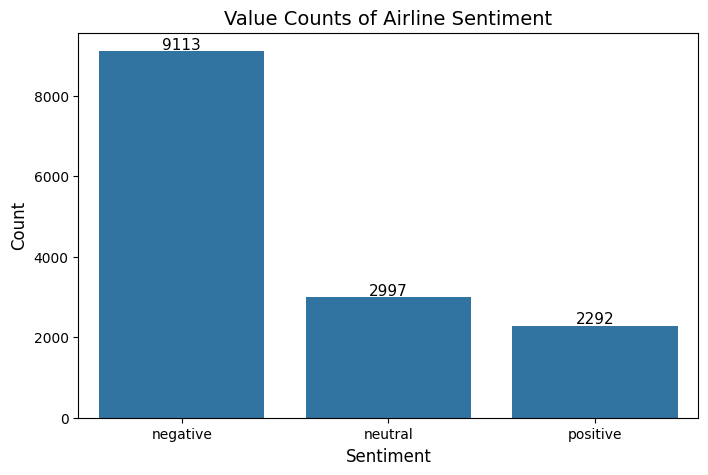

In [22]:
classes = df['airline_sentiment'].value_counts()
plt.figure(figsize=(8,5))
sns.barplot(x = classes.index, y = classes.values)

plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Value Counts of Airline Sentiment", fontsize=14)

for i, count in enumerate(classes.values):
    plt.text(i, count + 50, str(count), ha='center', fontsize=11)

plt.show()

There is a huge difference in the negative and other classes which can affect the model to be dominated by negative sentiment. Hence the classes needs to be balanced before training the model

### Balancing & Training the model

In [23]:
# Define input (X) and target (y)
x = df['clean_text']
y = df['airline_sentiment']

In [24]:
# Convert text into numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(x)

In [26]:
# Balancing the classes using SMOTETomek
from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state = 42)
x_balanced, y_balanced = smote_tomek.fit_resample(X_tfidf,y)

In [27]:
# Train and evaluate using cross-validation
model = MultinomialNB()
scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
scores = cross_validate(model, x_balanced, y_balanced,cv = 5, scoring= scoring_metrics)

In [30]:
print(f"Accuracy: {scores['test_accuracy'].mean():.4f}")
print(f"Precision: {scores['test_precision_macro'].mean():.4f}")
print(f"Recall: {scores['test_recall_macro'].mean():.4f}")
print(f"F1-score: {scores['test_f1_macro'].mean():.4f}")

Accuracy: 0.8146
Precision: 0.8157
Recall: 0.8146
F1-score: 0.8131
